In [6]:
library(Seurat)
library(dplyr)
library(magrittr)
library(ggplot2)
library(RColorBrewer)
library(tidyr)
library(dplyr)
library(readxl)
library(stringr)

In [7]:
set.seed(1)

In [238]:
#     mut_counts = apply(mutations_df, 2, sum)
#     if (color_by == "mut_counts") {
#         color_by_df = tibble(grp = mut_counts)
#     } else if (color_by == "provenance") {
#         color_by_df = tibble(grp = provenance)
#     } else if (color_by == "donor_vital_status") {
#         color_by_df = tibble(grp = donor_vital_status)
#     } else if (color_by == "donor_age_at_diagnosis") {
#         color_by_df = tibble(grp = donor_age_at_diagnosis)
#     } else if (color_by == "donor_survival_time") {
#         color_by_df = tibble(grp = donor_survival_time)
#     } else if (color_by == "donor_interval_of_last_followup") {
#         color_by_df = tibble(grp = donor_interval_of_last_followup)
#     }
    
#     color_by_df = color_by_df %>% 
#                   group_by(grp) %>% 
#                   transmute(grp = paste0(grp, "_", row_number()))
    
#     colnames(mutations_df) = t(color_by_df["grp"])

#         } else if (color_by == "donor_vital_status") {
#         color_by_df = tibble(grp = donor_vital_status)
#     } else if (color_by == "donor_age_at_diagnosis") {
#         color_by_df = tibble(grp = donor_age_at_diagnosis)
#     } else if (color_by == "donor_survival_time") {
#         color_by_df = tibble(grp = donor_survival_time)
#     } else if (color_by == "donor_interval_of_last_followup") {
#         color_by_df = tibble(grp = donor_interval_of_last_followup)
#     }

In [8]:
load_data <- function(filename) {
    df = read.csv(paste("../data/processed_data/mutations_with_subtypes", 
                        filename, sep="/"))
    return(df)
}

drop_low_count_samples  <- function(mutations_df, bottom_n_remove, subtypes,
                                    provenance, donor_ids, donor_vital_status, 
                                    donor_age_at_diagnosis, donor_survival_time, 
                                    donor_interval_of_last_followup) {
    counts = apply(mutations_df, 2, sum)
    idx = order(counts)[(bottom_n_remove+1):length(counts)]
    mutations_df = mutations_df[, idx]
    subtypes = subtypes[idx, ]
    provenance = provenance[idx, ]
    donor_ids = donor_ids[idx, ]
    donor_vital_status = donor_vital_status[idx, ]
    donor_age_at_diagnosis = donor_age_at_diagnosis[idx, ]
    donor_survival_time = donor_survival_time[idx, ]
    donor_interval_of_last_followup = donor_interval_of_last_followup[idx, ]

    return(list(mutations_df, subtypes, provenance, donor_ids, donor_vital_status,
                donor_age_at_diagnosis, donor_survival_time, donor_interval_of_last_followup))
}

In [165]:
perform_analysis <- function(df, 
                             bottom_n_remove,
                             n_highest_var_feats,
                             pca_n_components,
                             scale,
                             normalize,
                             norm_method,
                             dims_for_UMAP,
                             plot_title,
                             color_by,
                             approx_svd,
                             regress_by_counts,
                             seurat_clustering,
                             clustering_res,
                             neighbor_dims,
                             conduct_test,
                             save_clustered_mutations=FALSE) {
    provenance = df["provenance"]
    subtypes = df["subtype"]
    donor_ids = df["donor_id"]
    donor_vital_status = df["donor_vital_status"]
    donor_age_at_diagnosis = df["donor_age_at_diagnosis"]
    donor_survival_time = df["donor_survival_time"]
    donor_interval_of_last_followup = df["donor_interval_of_last_followup"]

    chr_ranges = colnames(df)[grepl("chr", colnames(df))]
    mutations_df = df[, !(colnames(df) %in% c("provenance", "subtype", "donor_id",
                                              "donor_vital_status", "donor_age_at_diagnosis", 
                                              "donor_survival_time", "donor_interval_of_last_followup"))]
    mutations_df = t(mutations_df)
    # Can replace with Seurat function
    l = drop_low_count_samples(mutations_df, bottom_n_remove, 
                               subtypes, provenance, donor_ids, 
                               donor_vital_status, donor_age_at_diagnosis,
                               donor_survival_time, donor_interval_of_last_followup)
    mutations_df = l[[1]]
    subtypes = l[[2]]
    provenance = l[[3]]
    donor_ids = l[[4]]
    donor_vital_status = l[[5]]
    donor_age_at_diagnosis = l[[6]]
    donor_survival_time = l[[7]]
    donor_interval_of_last_followup = l[[8]]

    colnames(mutations_df) = donor_ids
    seurat_data = CreateSeuratObject(counts = mutations_df)
    
    if (normalize) {
        seurat_data = NormalizeData(seurat_data, normalization.method=norm_method)
    }

    seurat_data = FindVariableFeatures(seurat_data, nfeatures = n_highest_var_feats)

    if (scale) {
        if (regress_by_counts) {
                seurat_data = ScaleData(seurat_data, verbose=F, vars.to.regress="nCount_RNA")
        }
        else {
            seurat_data = ScaleData(seurat_data, verbose=F)
        }
    }

    seurat_data = RunPCA(seurat_data, npcs=pca_n_components, verbose=F, approx=approx_svd)
    seurat_data = RunUMAP(object = seurat_data, dims=dims_for_UMAP, verbose=F)
    
    settings = paste0("top_", n_highest_var_feats,
                      "-",
                      "no_bottom_", bottom_n_remove, "_samples",
                      "-",
                      "scale_", scale,
                      "-",
                      "norm_by_mut_counts_", normalize,
                      "-", 
                      "pca_n_components_", pca_n_components,
                      "-",
                      "dims_for_UMAP_", paste0("1:", dims_for_UMAP[length(dims_for_UMAP)]),
                      "-",
                      "regress_by_counts_", regress_by_counts)
    
    if (seurat_clustering) {
        seurat_data = FindNeighbors(seurat_data, dims = neighbor_dims)
        seurat_data = FindClusters(seurat_data, resolution = clustering_res)
        clusters = Idents(seurat_data)
        settings = paste0(settings, "_clustering_res_", clustering_res)
        if (save_clustered_mutations) {
            mutations_df_sep = t(as_tibble(cbind(t(as.data.frame(mutations_df)), clusters, donor_ids)))
            mutations_df = as_tibble(cbind(t(as.data.frame(mutations_df)), clusters))
            mutations_df = mutations_df %>% 
                                group_by(clusters) %>%
                                summarize(across(everything(), sum)) 
            mutations_df = t(mutations_df)
            mutations_df = as_tibble(mutations_df)[2:nrow(mutations_df), ]
            clusters_names = paste("cluster", seq(from=0, to=ncol(mutations_df)-1), sep="_")
            colnames(mutations_df) = paste(plot_title, settings,
                                           clusters_names, 
                                           sep="x")
            rownames(mutations_df) = chr_ranges
            fn = paste0(settings, ".csv")
            path = paste("../data/processed_data/de_novo_seurat_clustered_mutations", 
                         plot_title, sep="/")
            fp = file.path(path, fn)
            dir.create(path, recursive=T)
            write.csv(mutations_df, fp)
            
            fn_sep = paste0(settings, "_separated.csv")
            fp_sep = file.path(path, fn_sep)
            write.csv(mutations_df_sep, fp_sep)
        }
        if (conduct_test) {
            clusters = split(clusters, names(clusters))
#             wilcox.test(group1, group2, alternative = "two.sided", 
#                         conf.int = TRUE)
        }
    }
    
#     seurat_data = RunTSNE(object = seurat_data, dims=dims_for_UMAP, verbose=F)
    seurat_data@meta.data$nCount_RNA = log(seurat_data@meta.data$nCount_RNA, base = exp(1))
    if (color_by == "mut_counts") {
        p = FeaturePlot(seurat_data, features = "nCount_RNA", shape.by="orig.ident", pt.size=2)
    } else if (color_by == "donor_age_at_diagnosis") {
        seurat_data = AddMetaData(object = seurat_data, metadata = 
                                  as.numeric(donor_age_at_diagnosis), 
                                  col.name = "donor_age_at_diagnosis")
        p = FeaturePlot(seurat_data, features = "donor_age_at_diagnosis", shape.by=NULL, pt.size=2)
    } else if (color_by == "donor_survival_time") {
        seurat_data = AddMetaData(object = seurat_data, metadata = 
                                  as.numeric(donor_survival_time), 
                                  col.name = "donor_survival_time")
        p = FeaturePlot(seurat_data, features = "donor_survival_time", shape.by=NULL, pt.size=2)
    } else if (color_by == "donor_interval_of_last_followup") {
        seurat_data = AddMetaData(object = seurat_data, metadata = 
                                  as.numeric(donor_survival_time), 
                                  col.name = "donor_interval_of_last_followup")
        p = FeaturePlot(seurat_data, features = "donor_interval_of_last_followup", shape.by=NULL, pt.size=2)     
    } else if (color_by == "provenance") {
        seurat_data = AddMetaData(object = seurat_data, metadata = 
                                  provenance, 
                                  col.name = "provenance")
        p = DimPlot(seurat_data, reduction = "umap", pt.size=1.5, group.by = "provenance") 
    } else if (color_by == "donor_vital_status") {
        seurat_data = AddMetaData(object = seurat_data, metadata = 
                                  donor_vital_status, 
                                  col.name = "donor_vital_status")
        p = DimPlot(seurat_data, reduction = "umap", pt.size=1.5, group.by = "donor_vital_status") 
    } else if (color_by == "subtype") {
        seurat_data = AddMetaData(object = seurat_data, metadata = 
                                  subtypes, 
                                  col.name = "subtype")
        p = DimPlot(seurat_data, reduction = "umap", pt.size=1.5, group.by = "subtype") 
    }
    else {
        p = DimPlot(seurat_data, reduction = "umap", pt.size=1.5) 
    }

    path = paste("..", "figures", "dim_reduced_data", "Seurat", plot_title, sep="/")
    dir.create(path)
    
    filename = paste0(settings,
                      "-",
                      "color_by_", color_by)

    filename = paste0(filename, ".png")

    filepath = paste(path, filename, sep="/")
    ggsave(filepath, plot = last_plot(), dpi = 300, width = 12, height = 8)
    print(p)
}

# Lung

In [14]:
df = load_data("lung.csv")

Warning message in file(file, "rt"):
“cannot open file '../data/processed_data/mutations_with_subtypes/lung.csv': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [281]:
df["provenance"] = ""
df["donor_vital_status"] = ""
df["donor_age_at_diagnosis"] = ""
df["donor_survival_time"] = ""
df["donor_interval_of_last_followup"] = ""
df["donor_id"] = seq(1, 84)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 84
Number of edges: 2434

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.3728
Number of communities: 2
Elapsed time: 0 seconds


Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/Lung' already exists”


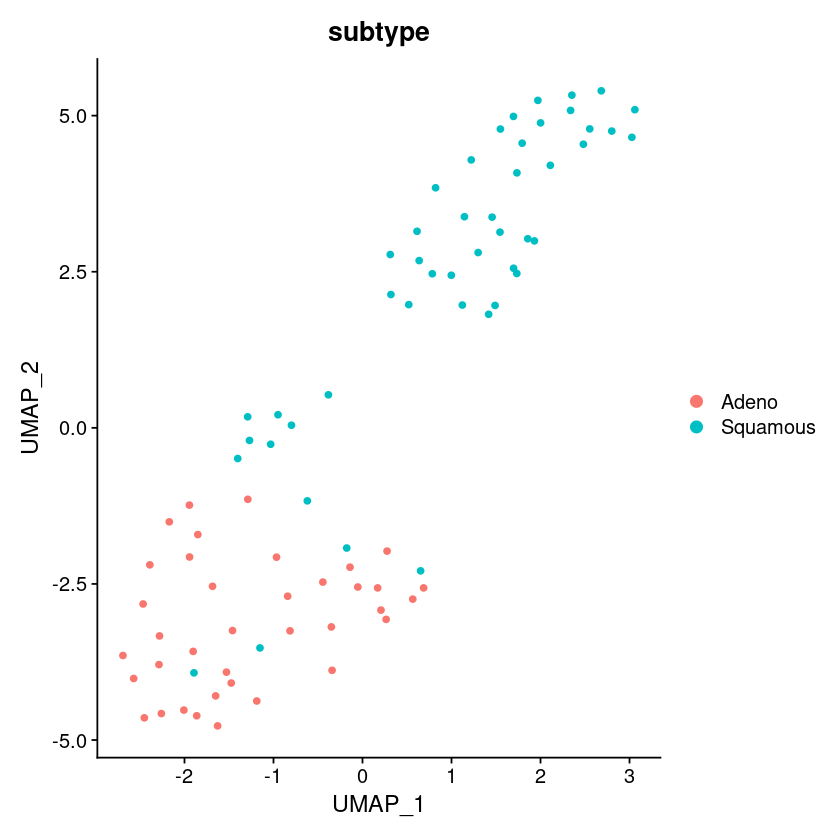

In [107]:
perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2128,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:15,
                 plot_title = "Lung",
                 color_by = "subtype",
                 regress_by_counts = T,
                 approx_svd=F,
                 seurat_clustering=T,
                 clustering_res=1,
                 neighbor_dims = 1:20,
                 save_clustered_mutations=F)

In [69]:
bottom_n_remove = 0
n_highest_var_feats = 2128
pca_n_components = 30
scale = T
normalize = T
norm_method = "LogNormalize"
dims_for_UMAP = 1:15
plot_title = "Lung"
color_by = "subtype"
regress_by_counts = T
approx_svd=F
seurat_clustering=T
clustering_res=1
neighbor_dims = 1:20
save_clustered_mutations=F

In [71]:
provenance = df["provenance"]
subtypes = df["subtype"]
donor_ids = df["donor_id"]
donor_vital_status = df["donor_vital_status"]
donor_age_at_diagnosis = df["donor_age_at_diagnosis"]
donor_survival_time = df["donor_survival_time"]
donor_interval_of_last_followup = df["donor_interval_of_last_followup"]

In [76]:
chr_ranges = colnames(df)[grepl("chr", colnames(df))]

In [81]:
mutations_df = df[, !(colnames(df) %in% c("provenance", "subtype", "donor_id",
                                          "donor_vital_status", "donor_age_at_diagnosis", 
                                          "donor_survival_time", "donor_interval_of_last_followup"))]


In [83]:
mutations_df = t(mutations_df)

In [85]:
l = drop_low_count_samples(mutations_df, bottom_n_remove, 
                           subtypes, provenance, donor_ids, 
                           donor_vital_status, donor_age_at_diagnosis,
                           donor_survival_time, donor_interval_of_last_followup)


In [88]:
mutations_df = l[[1]]
subtypes = l[[2]]
provenance = l[[3]]
donor_ids = l[[4]]
donor_vital_status = l[[5]]
donor_age_at_diagnosis = l[[6]]
donor_survival_time = l[[7]]
donor_interval_of_last_followup = l[[8]]


In [89]:
colnames(mutations_df) = donor_ids


In [90]:
seurat_data = CreateSeuratObject(counts = mutations_df)


In [95]:
seurat_data = NormalizeData(seurat_data, normalization.method=norm_method)

In [97]:
seurat_data = FindVariableFeatures(seurat_data, nfeatures = n_highest_var_feats)

In [100]:
seurat_data = ScaleData(seurat_data, verbose=F, vars.to.regress="nCount_RNA")

In [103]:
seurat_data = RunPCA(seurat_data, npcs=pca_n_components, verbose=F, approx=approx_svd)
seurat_data = RunUMAP(object = seurat_data, dims=dims_for_UMAP, verbose=F)


In [108]:
seurat_data@meta.data$nCount_RNA = log(seurat_data@meta.data$nCount_RNA, base = exp(1))

In [111]:
p = DimPlot(seurat_data, reduction = "umap", pt.size=1.5) 

In [112]:
path = paste("..", "figures", "dim_reduced_data", "Seurat", plot_title, sep="/")

In [ ]:
if (color_by == "mut_counts") {
    p = FeaturePlot(seurat_data, features = "nCount_RNA", shape.by="orig.ident", pt.size=2)
} else if (color_by == "donor_age_at_diagnosis") {
    donor_age_at_diagnosis = as.numeric(donor_age_at_diagnosis)
    seurat_data = AddMetaData(object = seurat_data, metadata = 
                              donor_age_at_diagnosis, 
                              col.name = "donor_age_at_diagnosis")
    p = FeaturePlot(seurat_data, features = "donor_age_at_diagnosis", shape.by=NULL, pt.size=2)
} else if (color_by == "donor_survival_time") {
    seurat_data = AddMetaData(object = seurat_data, metadata = 
                              donor_survival_time, 
                              col.name = "donor_survival_time")
    p = FeaturePlot(seurat_data, features = "donor_survival_time", shape.by=NULL, pt.size=2)
} else if (color_by == "donor_interval_of_last_followup") {
    seurat_data = AddMetaData(object = seurat_data, metadata = 
                              donor_survival_time, 
                              col.name = "donor_interval_of_last_followup")
    p = FeaturePlot(seurat_data, features = "donor_interval_of_last_followup", shape.by=NULL, pt.size=2)     
} else if (color_by == "provenance") {
    seurat_data = AddMetaData(object = seurat_data, metadata = 
                              provenance, 
                              col.name = "provenance")
    p = DimPlot(seurat_data, reduction = "umap", pt.size=1.5, group.by = "provenance") 
} else if (color_by == "donor_vital_status") {
    seurat_data = AddMetaData(object = seurat_data, metadata = 
                              donor_survival_time, 
                              col.name = "donor_survival_time")
    p = DimPlot(seurat_data, reduction = "umap", pt.size=1.5, group.by = "donor_survival_time") 
} else if (color_by == "subtype") {
    seurat_data = AddMetaData(object = seurat_data, metadata = 
                              subtypes, 
                              col.name = "subtype")
    p = DimPlot(seurat_data, reduction = "umap", pt.size=1.5, group.by = "subtype") 
}
else {
    p = DimPlot(seurat_data, reduction = "umap", pt.size=1.5) 
}

path = paste("..", "figures", "dim_reduced_data", "Seurat", plot_title, sep="/")
dir.create(path)

filename = paste0(settings,
                  "-",
                  "color_by_", color_by)

filename = paste0(filename, ".png")

filepath = paste(path, filename, sep="/")
ggsave(filepath, plot = last_plot(), dpi = 300, width = 12, height = 8)
print(p)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 37
Number of edges: 666

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.0162
Number of communities: 2
Elapsed time: 0 seconds


Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/lung_adeno' already exists”


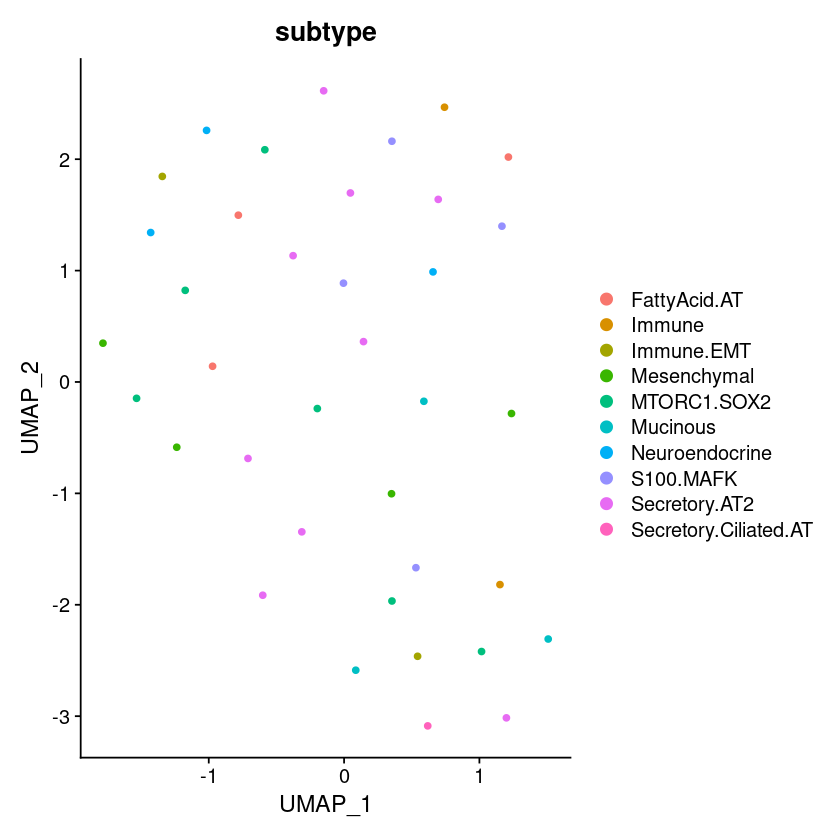

In [119]:
df = load_data("lung_adeno.csv")

df["provenance"] = ""
df["donor_vital_status"] = ""
df["donor_age_at_diagnosis"] = ""
df["donor_survival_time"] = ""
df["donor_interval_of_last_followup"] = ""
df["donor_id"] = seq(1, 37)

perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2128,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:15,
                 plot_title = "lung_adeno",
                 color_by = "subtype",
                 regress_by_counts = T,
                 approx_svd=F,
                 seurat_clustering=T,
                 clustering_res=1,
                 neighbor_dims = 1:20,
                 save_clustered_mutations=F
                )

In [321]:
df = load_data("lung_squamous.csv")

perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 1000,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:15,
                 plot_title = "lung_squamous",
                 subtype_by_color = T,
                 approx_svd=F
                )

ERROR: Error in perform_analysis(df, bottom_n_remove = 0, n_highest_var_feats = 1000, : unused argument (subtype_by_color = T)


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/lung_meso' already exists”


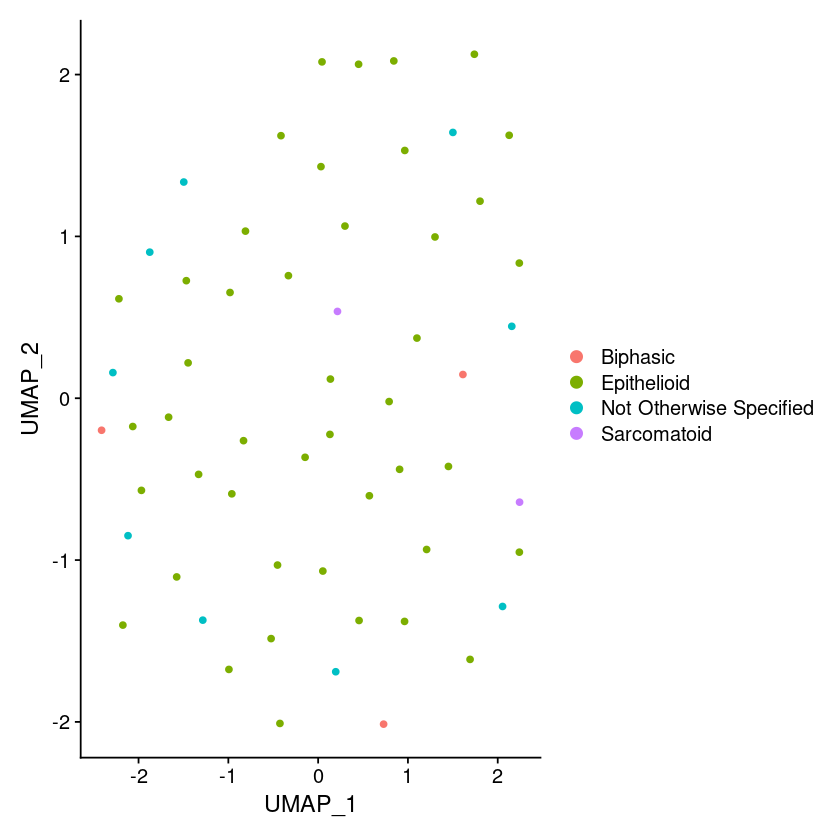

In [6]:
df = load_data("lung_meso.csv")

perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2000,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize", 
                 dims_for_UMAP = 1:15,
                 plot_title = "lung_meso",
                 subtype_by_color = T,
                 approx_svd=FALSE
                )

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 84
Number of edges: 2434

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.3728
Number of communities: 2
Elapsed time: 0 seconds


Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/squamous_subtypes_and_adeno' already exists”


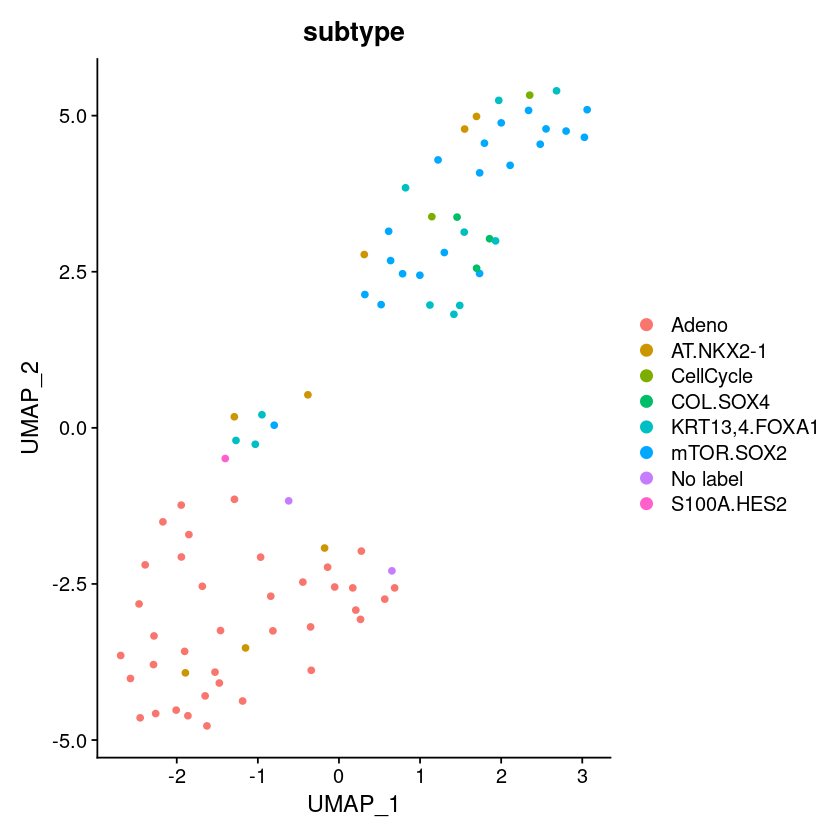

In [121]:
df = load_data("squamous_subtypes_and_lung_adeno.csv")

df["provenance"] = ""
df["donor_vital_status"] = ""
df["donor_age_at_diagnosis"] = ""
df["donor_survival_time"] = ""
df["donor_interval_of_last_followup"] = ""
df["donor_id"] = seq(1, 84)

perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2128,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:15,
                 plot_title = "squamous_subtypes_and_adeno",
                 color_by = "subtype",
                 regress_by_counts = T,
                 approx_svd=F,
                 seurat_clustering=T,
                 clustering_res=1,
                 neighbor_dims = 1:20,
                 save_clustered_mutations=F
                )

In [29]:
sum(df["subtype"] == "mTOR.SOX2")

[1] 20

In [28]:
df = load_data("all_lung.csv")

perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 1000,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:15,
                 plot_title = "all_lung",
                 subtype_by_color = T,
                 approx_svd=F,
                 regress_by_counts=T
                )

ERROR: Error in perform_analysis(df, bottom_n_remove = 0, n_highest_var_feats = 1000, : unused argument (subtype_by_color = T)


Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/SCLC' already exists”


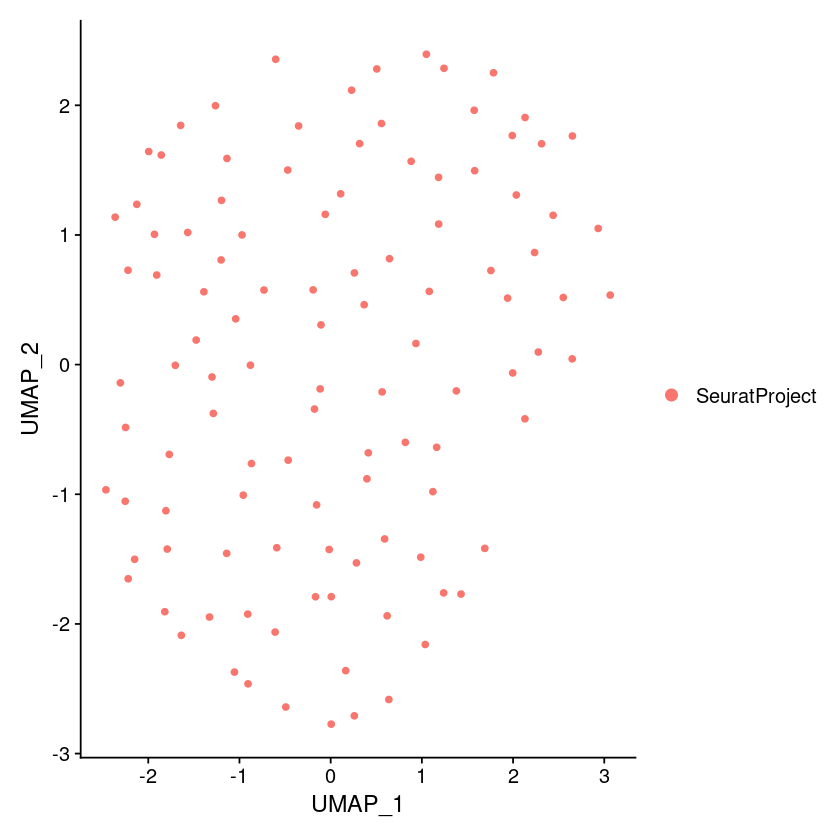

In [135]:
df = load_data("SCLC.csv")

df["provenance"] = ""
df["donor_vital_status"] = ""
df["donor_age_at_diagnosis"] = ""
df["donor_survival_time"] = ""
df["donor_interval_of_last_followup"] = ""
df["donor_id"] = seq(1, 109)

perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2128,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:20,
                 plot_title = "SCLC",
                 color_by = "seurat",
                 regress_by_counts = T,
                 approx_svd=F,
                 seurat_clustering=F,
                 clustering_res=0.7,
                 neighbor_dims = 1:20,
                 save_clustered_mutations=F
                )

# Medullo

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 141
Number of edges: 8568

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.3688
Number of communities: 2
Elapsed time: 0 seconds


Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/Medullo' already exists”


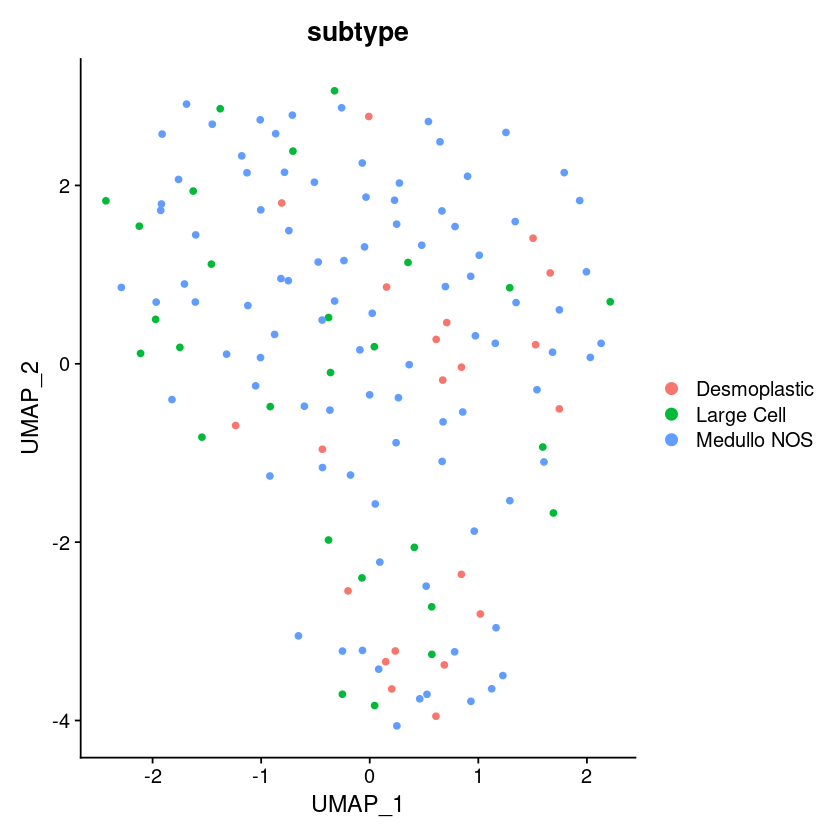

In [129]:
df = load_data("medulloblastoma.csv")

df["provenance"] = ""
df["donor_vital_status"] = ""
df["donor_age_at_diagnosis"] = ""
df["donor_survival_time"] = ""
df["donor_interval_of_last_followup"] = ""
df["donor_id"] = seq(1, 141)

perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2128,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:15,
                 plot_title = "Medullo",
                 color_by = "subtype",
                 regress_by_counts = T,
                 approx_svd=F,
                 seurat_clustering=T,
                 clustering_res=0.7,
                 neighbor_dims = 1:20,
                 save_clustered_mutations=F
                )

# Kidney

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 186
Number of edges: 7121

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.5946
Number of communities: 3
Elapsed time: 0 seconds


Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/Kidney' already exists”


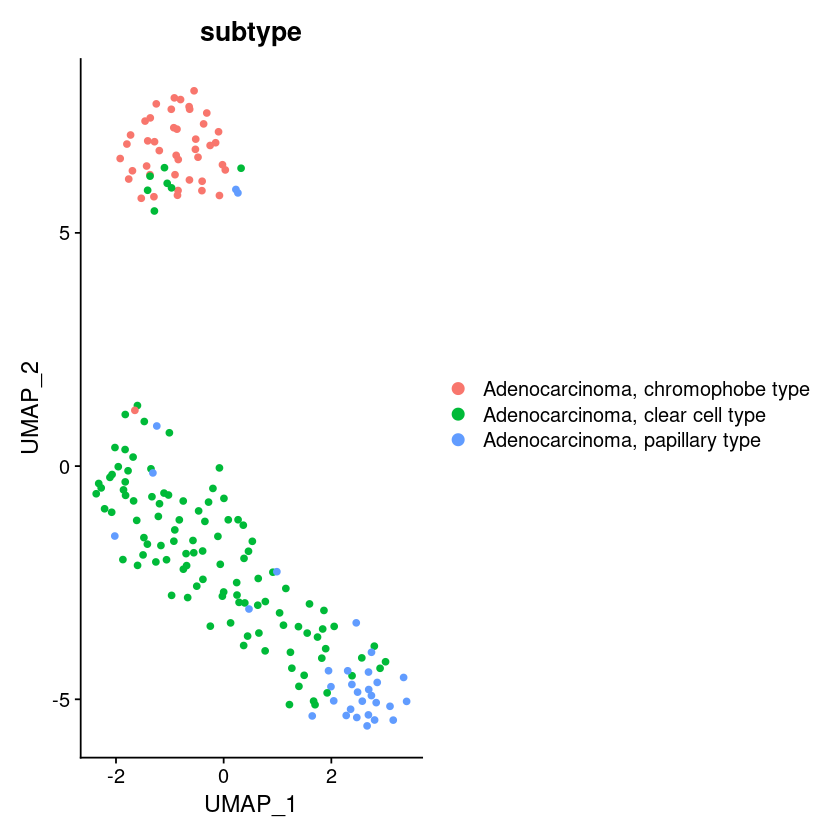

In [13]:
df = load_data("kidney_all.csv")

df["provenance"] = ""
df["donor_vital_status"] = ""
df["donor_age_at_diagnosis"] = ""
df["donor_survival_time"] = ""
df["donor_interval_of_last_followup"] = ""
df["donor_id"] = seq(1, 186)

perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2000,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:15,
                 plot_title = "Kidney",
                 color_by = "subtype",
                 regress_by_counts = T,
                 approx_svd=F,
                 seurat_clustering=T,
                 clustering_res=0.7,
                 neighbor_dims = 1:20,
                 save_clustered_mutations=F
                )

# Pancreas

In [238]:
df = load_data("pancreas_all.csv")

In [17]:
perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2128,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize", 
                 dims_for_UMAP = 1:15,
                 plot_title = "Pancreas",
                 plot_type = "color_provenance",
                 regress_by_counts = F,
                 approx_svd=F
                )

ERROR: Error in perform_analysis(df, bottom_n_remove = 0, n_highest_var_feats = 2128, : unused argument (plot_type = "color_provenance")


In [239]:
pancreas_adeno_only = df[!(df["subtype"] == "Neoroendocrine carcinoma"), ]

In [240]:
table(df["subtype"])

subtype
                                                Acinar cell carcinoma 
                                 2                                  1 
                    Adenocarcinoma           Adenocarcinoma, mucinous 
                                60                                  4 
          Carcinoma, adenosquamous Invasive carcinoma arising in IPMN 
                                 4                                  6 
          Neoroendocrine carcinoma        Pancreatic ductal carcinoma 
                                47                                155 

In [241]:
df[df["subtype"] == "", ]

,subtype,donor_id,chr1.5,chr1.6,chr1.7,chr1.8,chr1.9,chr1.11,chr1.12,chr1.15,⋯,chr9.124,chr9.125,chr9.126,chr9.127,chr9.131,chr9.132,chr9.133,chr9.135,chr9.137,provenance
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
166,,DO49454,2,1,1,2,0,0,0,5,⋯,0,0,1,1,0,2,1,5,2,PACA-CA
167,,DO49442,5,2,0,2,0,2,1,1,⋯,3,0,0,2,1,1,0,1,1,PACA-CA


In [243]:
df[df["subtype"] == "", ]

,subtype,donor_id,chr1.5,chr1.6,chr1.7,chr1.8,chr1.9,chr1.11,chr1.12,chr1.15,⋯,chr9.124,chr9.125,chr9.126,chr9.127,chr9.131,chr9.132,chr9.133,chr9.135,chr9.137,provenance
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
166,,DO49454,2,1,1,2,0,0,0,5,⋯,0,0,1,1,0,2,1,5,2,PACA-CA
167,,DO49442,5,2,0,2,0,2,1,1,⋯,3,0,0,2,1,1,0,1,1,PACA-CA


In [244]:
unique(pancreas_adeno_only["subtype"])

,subtype
,<chr>
1,Pancreatic ductal carcinoma
3,"Carcinoma, adenosquamous"
5,Invasive carcinoma arising in IPMN
46,"Adenocarcinoma, mucinous"
58,Acinar cell carcinoma
92,Adenocarcinoma
166,


In [18]:
perform_analysis(pancreas_adeno_only, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2000,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:15,
                 plot_title = "Pancreas_Adeno",
                 color_by = "mut_counts",
                 regress_by_counts = F,
                 approx_svd=F,
                 seurat_clustering=F,
                 clustering_res=0.2,
                 neighbor_dims = 1:20,
                 save_clustered_mutations=F)

ERROR: Error in perform_analysis(pancreas_adeno_only, bottom_n_remove = 0, n_highest_var_feats = 2000, : object 'pancreas_adeno_only' not found


In [105]:
df_with_cluster_assign = t(as.data.frame(mutations_df))

In [106]:
clusters = data.frame(clusters)

In [107]:
df_with_cluster_assign = merge(df_with_cluster_assign, clusters, by = "row.names")

In [111]:
df_with_cluster_assign = df_with_cluster_assign[2:ncol(df_with_cluster_assign)]

In [112]:
a = split(df_with_cluster_assign, df_with_cluster_assign["clusters"])

In [113]:
a = lapply(a, "[", 1:ncol(a[[1]])-1)

In [121]:
a = lapply(a, colSums)

In [124]:
a = do.call(cbind, a)

In [128]:
colnames(a) = c("panc_adeno_cluster_0", "panc_adeno_cluster_1")

In [129]:
write.csv(a, "de_novo_clustered_panc_adeno_mutations.csv")

In [170]:
df = load_data("pancreas_neuroendocrine.csv")

In [171]:
clinical_data = read_excel("../data/pcawg_donor_clinical_August2016_v9.xlsx")

In [172]:
donors = df[["donor_id"]]

In [173]:
neuroendo_clinical_data = clinical_data[clinical_data[["icgc_donor_id"]] %in% donors, ]

In [174]:
neuroendo_clinical_data = neuroendo_clinical_data[c("donor_vital_status", "donor_age_at_diagnosis", 
                          "donor_survival_time", "donor_interval_of_last_followup",
                          "icgc_donor_id")]

In [175]:
colnames(neuroendo_clinical_data) = c("donor_vital_status", "donor_age_at_diagnosis", 
                                      "donor_survival_time", "donor_interval_of_last_followup",
                                      "donor_id")

In [176]:
df = merge(df, neuroendo_clinical_data)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 81
Number of edges: 2110

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.3011
Number of communities: 3
Elapsed time: 0 seconds


Warning message:
“Setting row names on a tibble is deprecated.”
Warning message in dir.create(path, recursive = T):
“'../data/processed_data/de_novo_seurat_clustered_mutations/panc_neuroendocrine' already exists”
Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/panc_neuroendocrine' already exists”


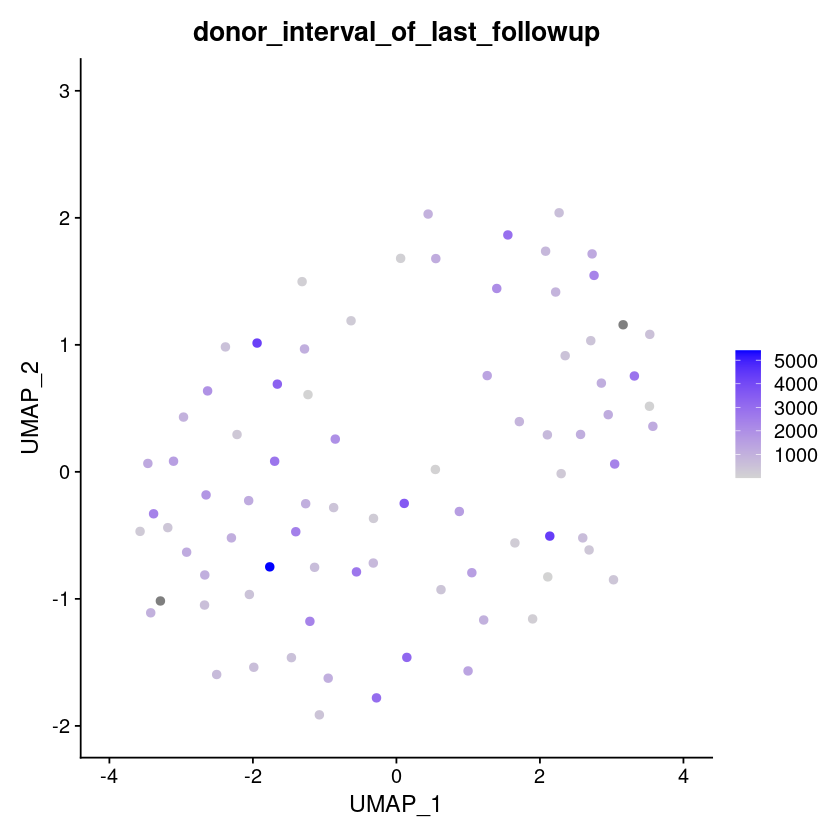

In [199]:
perform_analysis(df,
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2000,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:15,
                 plot_title = "panc_neuroendocrine",
                 color_by = "donor_interval_of_last_followup",
                 regress_by_counts = F,
                 approx_svd=F,
                 seurat_clustering=T,
                 clustering_res=1,
                 neighbor_dims = 1:20,
                 save_clustered_mutations=T)

In [185]:
df_with_de_novo_clusters = read.csv("../data/processed_data/de_novo_seurat_clustered_mutations/panc_neuroendocrine/top_2000-no_bottom_0_samples-scale_TRUE-norm_by_mut_counts_TRUE-pca_n_components_30-dims_for_UMAP_1:15-regress_by_counts_TRUE_clustering_res_1.csv")

In [186]:
colnames(df_with_de_novo_clusters) = c("chr", "cluster_0", "cluster_1")

In [187]:
df_with_de_novo_clusters = as_tibble(df_with_de_novo_clusters)

In [188]:
df_with_de_novo_clusters = pivot_longer(df_with_de_novo_clusters, cols = c("cluster_0", "cluster_1"))

In [189]:
colnames(df_with_de_novo_clusters) = c("chr", "cluster", "num_mutations")

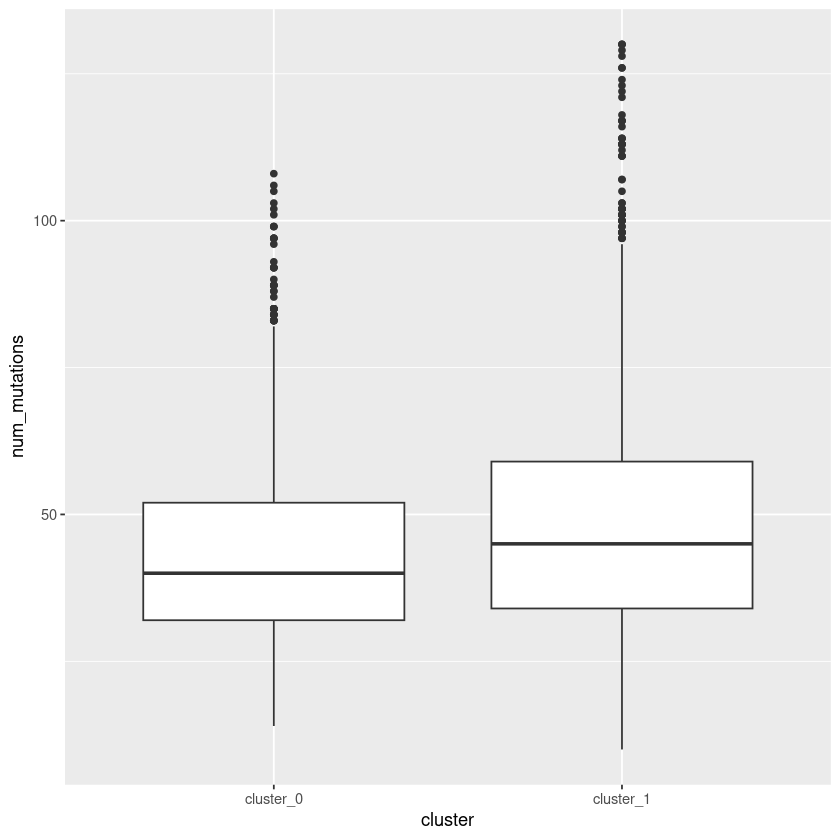

In [190]:
ggplot(df_with_de_novo_clusters, aes(cluster, num_mutations)) +
    geom_boxplot()

In [ ]:
perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2000,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:15,
                 plot_title = "Panc Neuroendocrine",
                 plot_type = "color_subtypes",
                 regress_by_counts = T,
                 approx_svd=F,
                 seurat_clustering=T,
                 clustering_res=0.9,
                 neighbor_dims = 1:20,
                 save_clustered_mutations=F)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 81
Number of edges: 2954

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.1774
Number of communities: 2
Elapsed time: 0 seconds


Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/SCLC' already exists”


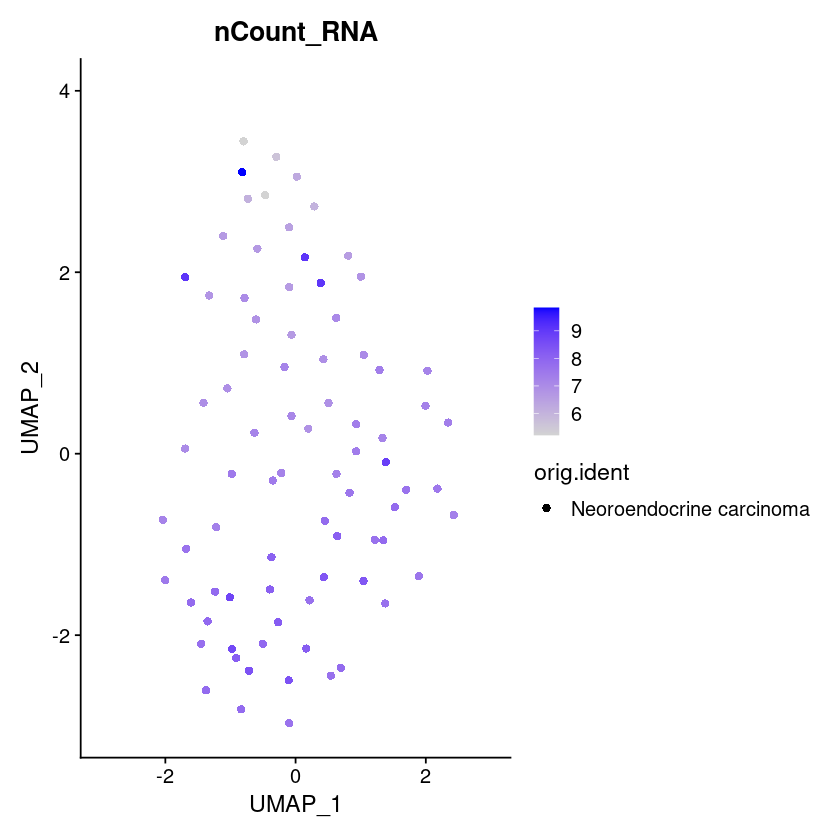

In [25]:
perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2000,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:15,
                 plot_title = "Panc Neuroendocrine",
                 plot_type = "mut_count_diff",
                 regress_by_counts = T,
                 approx_svd=F,
                 seurat_clustering=T,
                 clustering_res=0.9,
                 neighbor_dims = 1:20,
                 save_clustered_mutations=F)

Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/Panc Neuroendocrine' already exists”


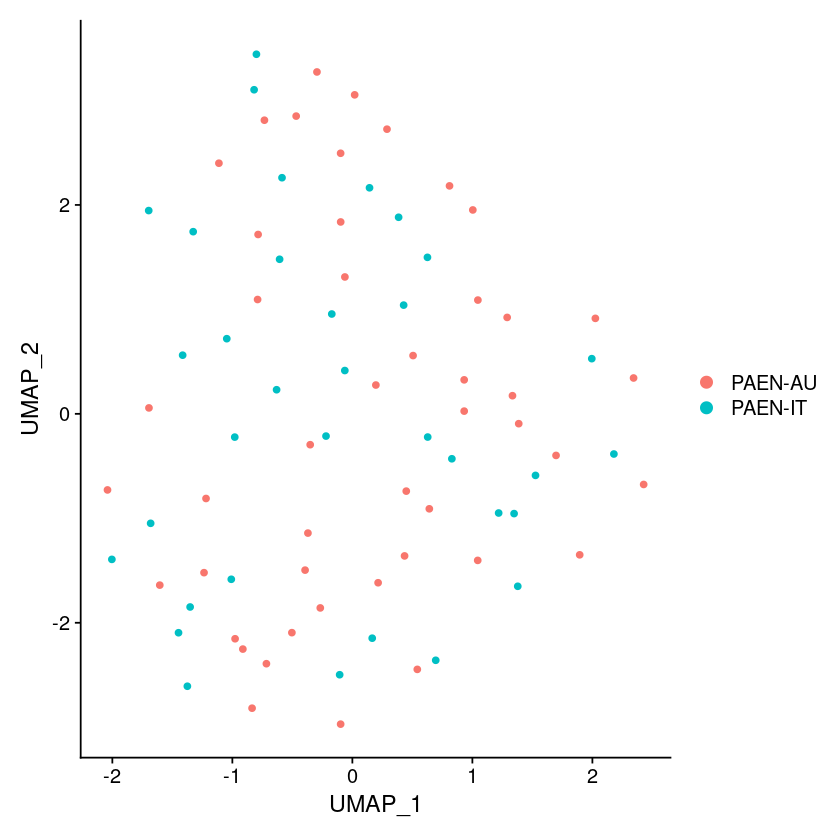

In [70]:
perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2000,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:15,
                 plot_title = "Panc Neuroendocrine",
                 plot_type = "color_provenance",
                 regress_by_counts = T,
                 approx_svd=F,
                 seurat_clustering=F,
                 clustering_res=0.9,
                 neighbor_dims = 1:20,
                 save_clustered_mutations=F)

# CPTAC

In [118]:
df = readRDS("../data/CPTAC/snp_1MB_profile_lung_CPTAC_3.RDS")
df = t(df)
colnames(df) = df[1, ]
df = as.data.frame(df[2:nrow(df), ])
df[] = lapply(df, as.numeric)
df["donor_id"] = unlist(lapply(strsplit(rownames(df), "__"), "[", 1))
df = df %>% 
        group_by(donor_id) %>%
        summarize(across(everything(), sum))

clinical_df = read.csv("../data/CPTAC/clinical_CPTAC3_available.tsv", sep="\t")
squamous_subtype = read.csv("../data/CPTAC/cptac.lusc.subtypes.csv")

squamous_subtype = as_tibble(squamous_subtype) %>% 
                        filter(!grepl(".N", X)) %>%
                        mutate(X = str_replace(X, "\\.", "-"))

colnames(squamous_subtype) = c("donor_id", "subtype")
case_id_to_case_submitted_id = clinical_df[, c("case_id", "case_submitter_id")]

df$donor_id = case_id_to_case_submitted_id[match(df$donor_id, case_id_to_case_submitted_id$case_id), 
                            "case_submitter_id"]

df = inner_join(df, squamous_subtype)

Joining with `by = join_by(donor_id)`


In [119]:
chr_keep = read.csv("../data/processed_data/chr_keep.csv")

In [120]:
df = df %>% select(c("donor_id", "subtype"), chr_keep[["chr"]])

In [121]:
df = as.data.frame(df)

In [122]:
df["provenance"] = "CPTAC"
df["donor_vital_status"] = ""
df["donor_age_at_diagnosis"] = ""
df["donor_survival_time"] = ""
df["donor_interval_of_last_followup"] = ""

In [123]:
df_TCGA_squamous = load_data("lung_squamous.csv")

In [124]:
df_TCGA_squamous["provenance"] = "TCGA"
df_TCGA_squamous["donor_vital_status"] = ""
df_TCGA_squamous["donor_age_at_diagnosis"] = ""
df_TCGA_squamous["donor_survival_time"] = ""
df_TCGA_squamous["donor_interval_of_last_followup"] = ""

In [125]:
df = rbind(df_TCGA_squamous,df)

Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/combined_TCGA_CPTAC_squamous' already exists”


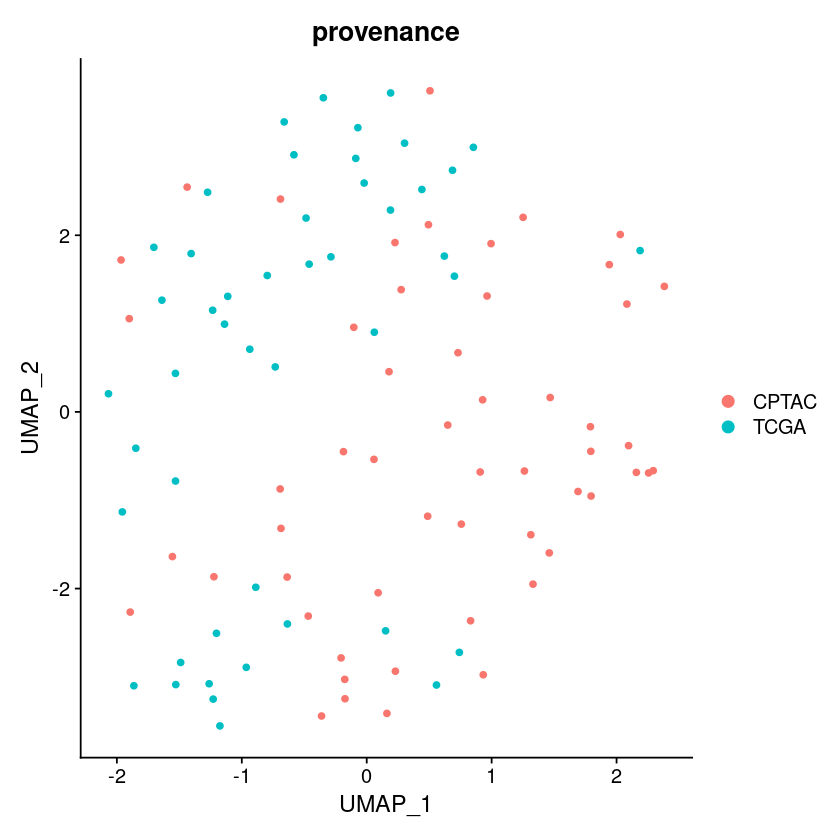

In [141]:
perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 1000,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:15,
                 plot_title = "combined_TCGA_CPTAC_squamous",
                 color_by = "provenance",
                 regress_by_counts = F,
                 approx_svd=F,
                 seurat_clustering=F,
                 clustering_res=1,
                 neighbor_dims = 1:20,
                 save_clustered_mutations=T)

In [144]:
df = readRDS("../data/CPTAC/snp_1MB_profile_lung_CPTAC_3.RDS")
df = t(df)
colnames(df) = df[1, ]
df = as.data.frame(df[2:nrow(df), ])
df[] = lapply(df, as.numeric)
df["donor_id"] = unlist(lapply(strsplit(rownames(df), "__"), "[", 1))
df = df %>% 
        group_by(donor_id) %>%
        summarize(across(everything(), sum))

clinical_df = read.csv("../data/CPTAC/clinical_CPTAC3_available.tsv", sep="\t")
adeno_subtype = read.csv("../data/CPTAC/cptac.luad.labels.csv")

adeno_subtype = as_tibble(adeno_subtype) %>% 
                        filter(!grepl(".N", X)) %>%
                        mutate(X = str_replace(X, "\\.", "-"))

colnames(adeno_subtype) = c("donor_id", "subtype")
case_id_to_case_submitted_id = clinical_df[, c("case_id", "case_submitter_id")]

df$donor_id = case_id_to_case_submitted_id[match(df$donor_id, case_id_to_case_submitted_id$case_id), 
                            "case_submitter_id"]

df = inner_join(df, adeno_subtype)

Joining with `by = join_by(donor_id)`


In [145]:
chr_keep = read.csv("../data/processed_data/chr_keep.csv")
df = df %>% select(c("donor_id", "subtype"), chr_keep[["chr"]])
df = as.data.frame(df)

df["provenance"] = "CPTAC"
df["donor_vital_status"] = ""
df["donor_age_at_diagnosis"] = ""
df["donor_survival_time"] = ""
df["donor_interval_of_last_followup"] = ""

In [146]:
df_TCGA_adeno = load_data("lung_adeno.csv")

In [147]:
colnames(df_TCGA_adeno)[1] = "subtype"

In [148]:
df_TCGA_adeno["provenance"] = "TCGA"
df_TCGA_adeno["donor_vital_status"] = ""
df_TCGA_adeno["donor_age_at_diagnosis"] = ""
df_TCGA_adeno["donor_survival_time"] = ""
df_TCGA_adeno["donor_interval_of_last_followup"] = ""

In [149]:
df = rbind(df_TCGA_adeno, df)

In [150]:
df

subtype,donor_id,chr1.5,chr1.6,chr1.7,chr1.8,chr1.9,chr1.11,chr1.12,chr1.15,⋯,chr9.131,chr9.132,chr9.133,chr9.135,chr9.137,provenance,donor_vital_status,donor_age_at_diagnosis,donor_survival_time,donor_interval_of_last_followup
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
FattyAcid.AT,DO25010,27,17,12,22,3,11,24,8,⋯,8,14,7,12,9,TCGA,,,,
MTORC1.SOX2,DO24307,7,7,6,3,1,5,6,3,⋯,6,4,5,6,1,TCGA,,,,
Secretory.AT2,DO23744,29,35,14,19,6,5,14,15,⋯,10,11,7,21,11,TCGA,,,,
S100.MAFK,DO23838,12,12,3,10,3,1,3,6,⋯,6,3,8,14,6,TCGA,,,,
Mesenchymal,DO23735,3,2,1,3,1,0,1,4,⋯,1,1,3,1,1,TCGA,,,,
S100.MAFK,DO25189,145,115,56,68,39,37,65,31,⋯,54,71,45,76,47,TCGA,,,,
Secretory.AT2,DO26062,6,0,3,4,0,1,1,1,⋯,1,3,0,3,1,TCGA,,,,
Neuroendocrine,DO25104,50,34,16,16,8,12,15,18,⋯,14,9,10,16,8,TCGA,,,,
Neuroendocrine,DO24675,28,22,13,11,2,11,8,6,⋯,3,14,5,22,7,TCGA,,,,


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 71
Number of edges: 1827

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.3205
Number of communities: 2
Elapsed time: 0 seconds


Warning message:
“Setting row names on a tibble is deprecated.”
Warning message in dir.create(path, recursive = T):
“'../data/processed_data/de_novo_seurat_clustered_mutations/combined_TCGA_CPTAC_adeno' already exists”


C3L-00083 C3L-00263 C3L-01683 C3L-02508   DO25737 C3L-00422   DO23648 C3L-00973 
        1         1         1         1         1         1         1         1 
C3L-02350 C3L-02549 C3L-00093   DO25887 C3L-00412 C3L-01330 C3L-01682   DO23651 
        1         1         1         1         1         1         1         1 
  DO23687 C3L-00604 C3L-02219 C3L-00510   DO24646   DO23942 C3L-02348 C3L-00001 
        1         1         1         0         0         0         0         0 
  DO23735   DO24497 C3L-00140   DO24130   DO23702 C3L-00893 C3L-00368   DO26062 
        0         0         0         0         0         0         0         0 
C3L-01862   DO25068 C3L-00913   DO23584 C3L-01632   DO23610   DO23786   DO26354 
        0         0         0         0         0         0         0         0 
C3L-00009   DO23608 C3L-00279 C3L-02345   DO25927 C3L-01889   DO24860   DO24307 
        0         0         0         0         0         0         0         0 
  DO24467 C3L-00094 C3L-0189

Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/combined_TCGA_CPTAC_adeno' already exists”


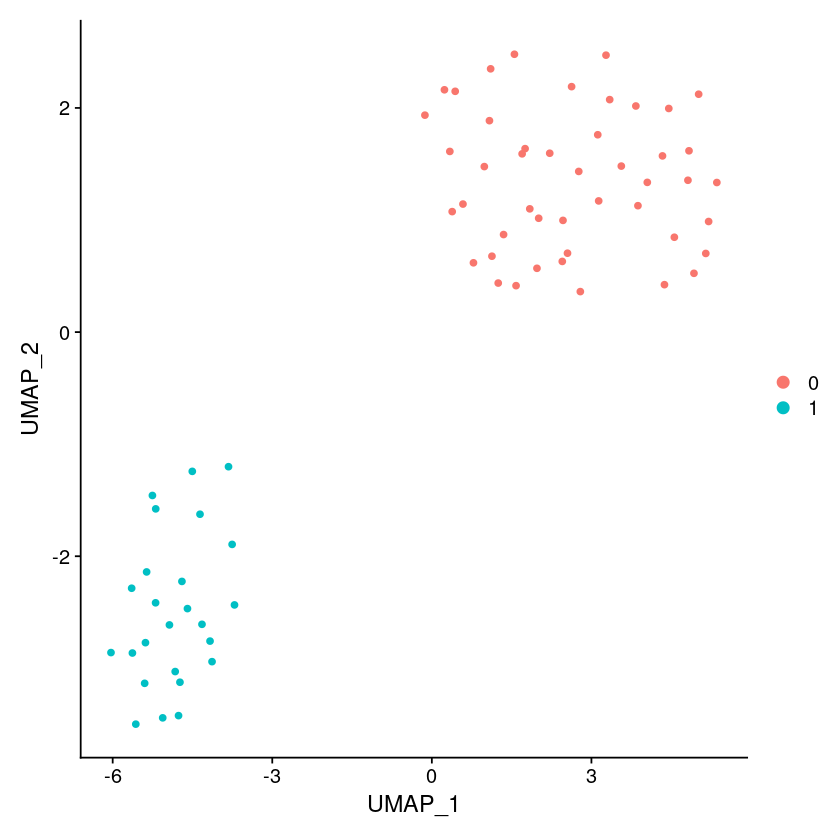

In [164]:
perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 1500,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:15,
                 plot_title = "combined_TCGA_CPTAC_adeno",
                 color_by = "seur",
                 regress_by_counts = T,
                 approx_svd=F,
                 seurat_clustering=T,
                 clustering_res=0.8,
                 neighbor_dims = 1:20,
                 conduct_test = T,
                 save_clustered_mutations=F)

In [167]:
bottom_n_remove = 0
n_highest_var_feats = 1500
pca_n_components = 30
scale = T
normalize = T
norm_method = "LogNormalize"
dims_for_UMAP = 1:15
plot_title = "combined_TCGA_CPTAC_adeno"
color_by = "seur"
regress_by_counts = T
approx_svd=F
seurat_clustering=T
clustering_res=0.8
neighbor_dims = 1:20
conduct_test = T
save_clustered_mutations=F

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 71
Number of edges: 1827

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.3205
Number of communities: 2
Elapsed time: 0 seconds


NULL

Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/combined_TCGA_CPTAC_adeno' already exists”


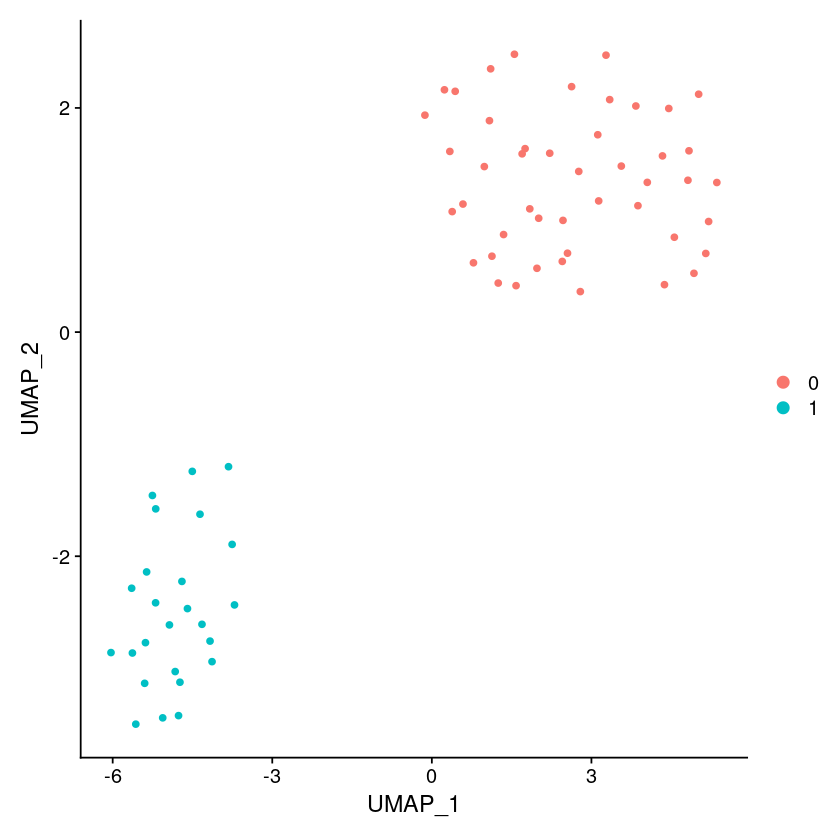

In [172]:
provenance = df["provenance"]
subtypes = df["subtype"]
donor_ids = df["donor_id"]
donor_vital_status = df["donor_vital_status"]
donor_age_at_diagnosis = df["donor_age_at_diagnosis"]
donor_survival_time = df["donor_survival_time"]
donor_interval_of_last_followup = df["donor_interval_of_last_followup"]

chr_ranges = colnames(df)[grepl("chr", colnames(df))]
mutations_df = df[, !(colnames(df) %in% c("provenance", "subtype", "donor_id",
                                          "donor_vital_status", "donor_age_at_diagnosis", 
                                          "donor_survival_time", "donor_interval_of_last_followup"))]
mutations_df = t(mutations_df)
# Can replace with Seurat function
l = drop_low_count_samples(mutations_df, bottom_n_remove, 
                           subtypes, provenance, donor_ids, 
                           donor_vital_status, donor_age_at_diagnosis,
                           donor_survival_time, donor_interval_of_last_followup)
mutations_df = l[[1]]
subtypes = l[[2]]
provenance = l[[3]]
donor_ids = l[[4]]
donor_vital_status = l[[5]]
donor_age_at_diagnosis = l[[6]]
donor_survival_time = l[[7]]
donor_interval_of_last_followup = l[[8]]

colnames(mutations_df) = donor_ids
seurat_data = CreateSeuratObject(counts = mutations_df)

if (normalize) {
    seurat_data = NormalizeData(seurat_data, normalization.method=norm_method)
}

seurat_data = FindVariableFeatures(seurat_data, nfeatures = n_highest_var_feats)

if (scale) {
    if (regress_by_counts) {
            seurat_data = ScaleData(seurat_data, verbose=F, vars.to.regress="nCount_RNA")
    } else {
        seurat_data = ScaleData(seurat_data, verbose=F)
    }
}

seurat_data = RunPCA(seurat_data, npcs=pca_n_components, verbose=F, approx=approx_svd)
seurat_data = RunUMAP(object = seurat_data, dims=dims_for_UMAP, verbose=F)

settings = paste0("top_", n_highest_var_feats,
                  "-",
                  "no_bottom_", bottom_n_remove, "_samples",
                  "-",
                  "scale_", scale,
                  "-",
                  "norm_by_mut_counts_", normalize,
                  "-", 
                  "pca_n_components_", pca_n_components,
                  "-",
                  "dims_for_UMAP_", paste0("1:", dims_for_UMAP[length(dims_for_UMAP)]),
                  "-",
                  "regress_by_counts_", regress_by_counts)

if (seurat_clustering) {
    seurat_data = FindNeighbors(seurat_data, dims = neighbor_dims)
    seurat_data = FindClusters(seurat_data, resolution = clustering_res)
    clusters = Idents(seurat_data)
    settings = paste0(settings, "_clustering_res_", clustering_res)
    if (save_clustered_mutations) {
        mutations_df_sep = t(as_tibble(cbind(t(as.data.frame(mutations_df)), clusters, donor_ids)))
        mutations_df = as_tibble(cbind(t(as.data.frame(mutations_df)), clusters))
        mutations_df = mutations_df %>% 
                            group_by(clusters) %>%
                            summarize(across(everything(), sum)) 
        mutations_df = t(mutations_df)
        mutations_df = as_tibble(mutations_df)[2:nrow(mutations_df), ]
        clusters_names = paste("cluster", seq(from=0, to=ncol(mutations_df)-1), sep="_")
        colnames(mutations_df) = paste(plot_title, settings,
                                       clusters_names, 
                                       sep="x")
        rownames(mutations_df) = chr_ranges
        fn = paste0(settings, ".csv")
        path = paste("../data/processed_data/de_novo_seurat_clustered_mutations", 
                     plot_title, sep="/")
        fp = file.path(path, fn)
        dir.create(path, recursive=T)
        write.csv(mutations_df, fp)

        fn_sep = paste0(settings, "_separated.csv")
        fp_sep = file.path(path, fn_sep)
        write.csv(mutations_df_sep, fp_sep)
    }
    if (conduct_test) {
#         clusters = split(clusters, names(clusters))
#             wilcox.test(group1, group2, alternative = "two.sided", 
#                         conf.int = TRUE)
    }
}

#     seurat_data = RunTSNE(object = seurat_data, dims=dims_for_UMAP, verbose=F)
seurat_data@meta.data$nCount_RNA = log(seurat_data@meta.data$nCount_RNA, base = exp(1))
if (color_by == "mut_counts") {
    p = FeaturePlot(seurat_data, features = "nCount_RNA", shape.by="orig.ident", pt.size=2)
} else if (color_by == "donor_age_at_diagnosis") {
    seurat_data = AddMetaData(object = seurat_data, metadata = 
                              as.numeric(donor_age_at_diagnosis), 
                              col.name = "donor_age_at_diagnosis")
    p = FeaturePlot(seurat_data, features = "donor_age_at_diagnosis", shape.by=NULL, pt.size=2)
} else if (color_by == "donor_survival_time") {
    seurat_data = AddMetaData(object = seurat_data, metadata = 
                              as.numeric(donor_survival_time), 
                              col.name = "donor_survival_time")
    p = FeaturePlot(seurat_data, features = "donor_survival_time", shape.by=NULL, pt.size=2)
} else if (color_by == "donor_interval_of_last_followup") {
    seurat_data = AddMetaData(object = seurat_data, metadata = 
                              as.numeric(donor_survival_time), 
                              col.name = "donor_interval_of_last_followup")
    p = FeaturePlot(seurat_data, features = "donor_interval_of_last_followup", shape.by=NULL, pt.size=2)     
} else if (color_by == "provenance") {
    seurat_data = AddMetaData(object = seurat_data, metadata = 
                              provenance, 
                              col.name = "provenance")
    p = DimPlot(seurat_data, reduction = "umap", pt.size=1.5, group.by = "provenance") 
} else if (color_by == "donor_vital_status") {
    seurat_data = AddMetaData(object = seurat_data, metadata = 
                              donor_vital_status, 
                              col.name = "donor_vital_status")
    p = DimPlot(seurat_data, reduction = "umap", pt.size=1.5, group.by = "donor_vital_status") 
} else if (color_by == "subtype") {
    seurat_data = AddMetaData(object = seurat_data, metadata = 
                              subtypes, 
                              col.name = "subtype")
    p = DimPlot(seurat_data, reduction = "umap", pt.size=1.5, group.by = "subtype") 
} else {
    p = DimPlot(seurat_data, reduction = "umap", pt.size=1.5) 
}

path = paste("..", "figures", "dim_reduced_data", "Seurat", plot_title, sep="/")
dir.create(path)

filename = paste0(settings,
                  "-",
                  "color_by_", color_by)

filename = paste0(filename, ".png")

filepath = paste(path, filename, sep="/")
ggsave(filepath, plot = last_plot(), dpi = 300, width = 12, height = 8)
print(p)

In [211]:
groups = as.data.frame(clusters) %>% 
            rownames_to_column(var = "donor_id") %>%
            group_by(clusters) %>%
            group_split()

In [212]:
groups

donor_id,clusters
<chr>,<fct>
C3L-00510,0
DO24646,0
DO23942,0
C3L-02348,0
C3L-00001,0
DO23735,0
DO24497,0
C3L-00140,0
DO24130,0


In [214]:
mutations_df

,C3L-00083,C3L-00263,C3L-01683,C3L-02508,DO25737,C3L-00422,DO23648,C3L-00973,C3L-02350,C3L-02549,⋯,DO25622,DO23744,DO25104,DO25985,DO25320,DO25847,C3L-00080,DO25797,DO25189,C3L-00144
chr1.5,0,0,0,0,1,0,1,0,0,2,⋯,37,29,50,41,45,111,81,57,145,37
chr1.6,0,0,0,0,0,0,0,0,0,1,⋯,30,35,34,41,53,62,78,47,115,42
chr1.7,0,0,0,0,0,0,0,0,0,0,⋯,10,14,16,15,22,20,28,26,56,21
chr1.8,0,0,0,0,0,0,0,0,0,1,⋯,8,19,16,18,31,27,35,20,68,30
chr1.9,0,0,0,0,0,0,0,0,0,0,⋯,4,6,8,10,15,14,10,19,39,15
chr1.11,0,0,0,0,0,0,0,0,0,0,⋯,4,5,12,12,13,20,11,19,37,18
chr1.12,0,0,0,0,0,1,0,0,0,0,⋯,7,14,15,18,28,19,29,30,65,29
chr1.15,0,0,0,0,0,0,0,0,0,1,⋯,18,15,18,9,22,27,15,14,31,27
chr1.16,0,1,0,0,0,0,1,0,0,0,⋯,8,18,15,10,18,35,16,13,52,19
chr1.19,0,0,0,0,0,0,0,0,1,0,⋯,14,19,23,39,52,54,51,36,97,92
